<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/using_real_world_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging

logging.set_verbosity(logging.ERROR)


In [ ]:
!gdown --id 1ZRIkTQOSm-yrhj6PNop-tMuMM8PRoETL


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZRIkTQOSm-yrhj6PNop-tMuMM8PRoETL
To: /content/daily-min-temperatures.csv
100% 67.9k/67.9k [00:00<00:00, 95.5MB/s]


In [ ]:
TEMPERATURES_CSV = "./daily-min-temperatures.csv"

with open(TEMPERATURES_CSV, 'r') as csvfile:
  print(f"Header looks like this:\n\n {csvfile.readline()}")
  print(f"First data point looks like this:\n\n {csvfile.readline()}")
  print(f"Second data point looks like this:\n\n {csvfile.readline()}")



Header looks like this:

 "Date","Temp"

First data point looks like this:

 "1981-01-01",20.7

Second data point looks like this:

 "1981-01-02",17.9



In [ ]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start: end], series[start: end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
def parse_data_from_file(filename):

  times = []
  temperatures = []

  with open(filename) as csvfile:

    # Initialize reader
    reader = csv.reader(csvfile, delimiter = ",")

    # Skip the first line
    next(reader)

    # Append row and temperature to lists
    for i,row in enumerate(reader):
      times.append(int(i))
      temperatures.append(float(row[1]))

  # times = np.array(times)
  # temperatures = np.array(temperatures)

  return times, temperatures


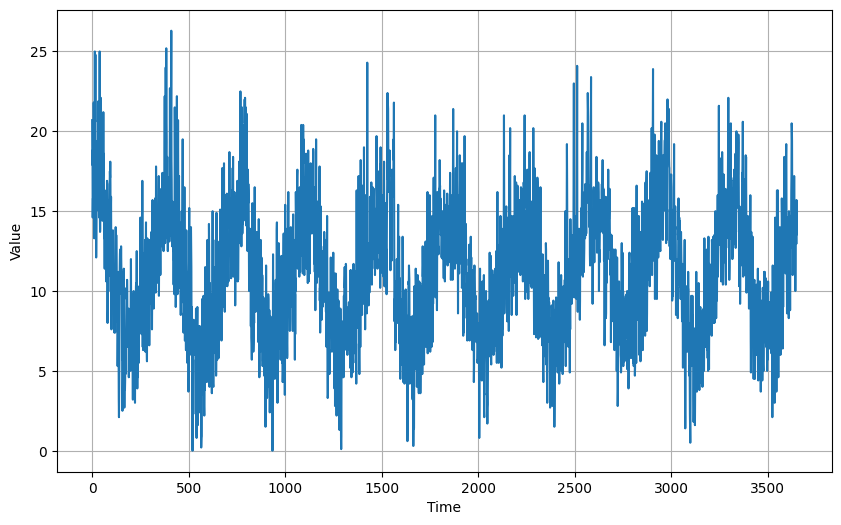

In [ ]:
# Test your function and save all "global" vaiables within the G class (G stands for global)
@dataclass
class G:
  TEMPERATURES_CSV = "./daily-min-temperatures.csv"
  times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
  TIME = np.array(times)
  SERIES = np.array(temperatures)
  SPLIT_TIME = 2500
  WINDOW_SIZE = 64
  BATCH_SIZE = 32
  SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize = (10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()



In [ ]:
def train_val_split(time, series, time_step = G.SPLIT_TIME):
  time_train = time[:time_step]
  series_train = series[:time_step]
  time_valid = time[time_step:]
  series_valid = series[time_step:]

  return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)


In [ ]:
def windowed_dataset(series, window_size = G.WINDOW_SIZE, batch_size = G.BATCH_SIZE, shuffle_buffer = G.SHUFFLE_BUFFER_SIZE):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[: -1], window[-1]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size = G.WINDOW_SIZE, batch_size = G.BATCH_SIZE, shuffle_buffer = G.SHUFFLE_BUFFER_SIZE)


In [ ]:
def create_uncompiled_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'causal', input_shape = [G.WINDOW_SIZE, 1]),
      tf.keras.layers.LSTM(64, return_sequences = True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(32, activation = 'relu'),
      tf.keras.layers.Dense(8, activation = 'relu'),
      tf.keras.layers.Dense(1)
  ])

  return model


In [ ]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
  # Generate a prediction
  print(f"Testing model prediction with input of shape {X.shape} ...")
  y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape,(f'Squeezed predicted y shape = {y_pred_shape} whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")




Testing model prediction with input of shape (32, 64) ...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
def adjust_learning_rate(dataset):

  model = create_uncompiled_model()

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

  # Select your optimizer
  optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

  # Compile the model passing in the appropriate loss
  model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])

  history = model.fit(dataset, epochs= 100, callbacks = [lr_schedule])

  return history


In [ ]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 5s 16ms/step - loss: 10.2148 - mae: 10.7137 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 1s 15ms/step - loss: 9.9650 - mae: 10.4636 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 1s 11ms/step - loss: 9.6222 - mae: 10.1206 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 1s 11ms/step - loss: 8.8384 - mae: 9.3358 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 1s 12ms/step - loss: 4.9799 - mae: 5.4603 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 1s 11ms/step - loss: 2.3088 - mae: 2.7682 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 1s 14ms/step - loss: 1.9378 - mae: 2.3900 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 2s 19ms/step - loss: 1.8350 - mae: 2.2870 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 1s 11ms/step - loss: 1.8138 - mae: 2.2668 - lr:

(0.0001, 10.0, 0.0, 10.0)

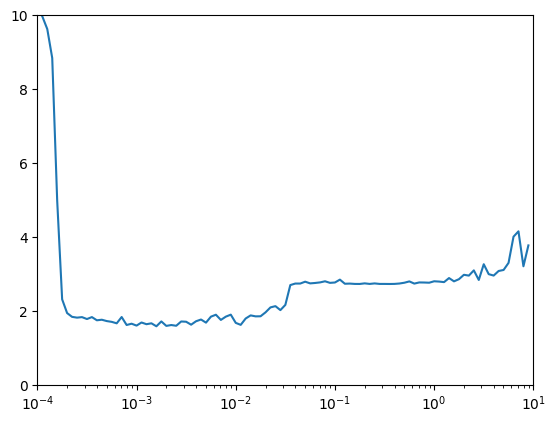

In [ ]:
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.axis([1e-4, 10, 0, 10])



In [ ]:
def create_model():
  model = create_uncompiled_model()

  model.compile(loss = tf.keras.losses.Huber(),
                optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-3, momentum = 0.9),
                metrics = ["mae"])

  return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs = 50)


Epoch 1/50
77/77 [==============================] - 4s 12ms/step - loss: 4.4193 - mae: 4.8950
Epoch 2/50
77/77 [==============================] - 1s 11ms/step - loss: 2.0885 - mae: 2.5431
Epoch 3/50
77/77 [==============================] - 1s 11ms/step - loss: 1.8605 - mae: 2.3140
Epoch 4/50
77/77 [==============================] - 1s 11ms/step - loss: 1.7752 - mae: 2.2255
Epoch 5/50
77/77 [==============================] - 1s 11ms/step - loss: 1.7847 - mae: 2.2381
Epoch 6/50
77/77 [==============================] - 1s 11ms/step - loss: 1.6970 - mae: 2.1480
Epoch 7/50
77/77 [==============================] - 2s 17ms/step - loss: 1.7234 - mae: 2.1713
Epoch 8/50
77/77 [==============================] - 1s 16ms/step - loss: 1.6239 - mae: 2.0731
Epoch 9/50
77/77 [==============================] - 1s 11ms/step - loss: 1.5783 - mae: 2.0237
Epoch 10/50
77/77 [==============================] - 1s 11ms/step - loss: 1.5824 - mae: 2.0285
Epoch 11/50
77/77 [==============================] - 1s 11m

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast



113/113 [==============================] - 2s 10ms/step


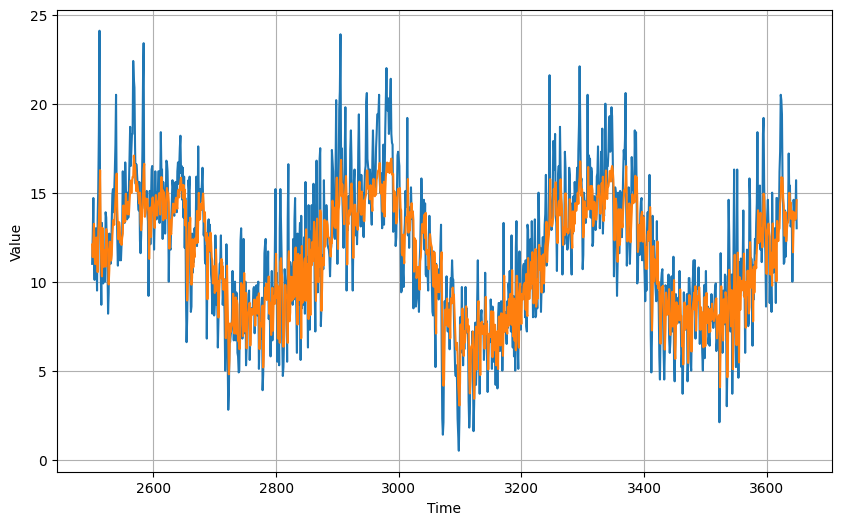

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)



In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.45, mae: 1.82 for forecast
